In [161]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import random
import time
import os
import pandas as pd
import math


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print("Pytorch: {}".format(torch.__version__))

Pytorch: 0.2.0_4


if False:
    import keras
    from keras import backend as K
    from keras.models import Sequential, Model
    from keras.layers.normalization import BatchNormalization
    from keras.utils.data_utils import get_file
    from keras.models import Sequential
    from keras.layers.core import Flatten, Dense, Dropout, Lambda
    from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
    from keras.layers.pooling import GlobalAveragePooling2D
    from keras.optimizers import SGD, RMSprop, Adam
    from keras.preprocessing import image
    print("Keras {}, TensorFlow {}".format(keras.__version__, keras.backend.tf.__version__))

# Data to train and validation 

In [3]:
all_data_org = pd.read_csv('data/en_train_org.csv')

In [4]:
all_data_org[pd.isnull(all_data_org['before'])][:3]

,sentence_id,token_id,class,before,after
616107,49226,17,LETTERS,NaN,n a
684691,54634,1,PLAIN,NaN,NaN
965529,76612,7,PLAIN,NaN,NaN


In [41]:
all_data = all_data_org.dropna()
print("Data rows: {},  (dropped none rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data[all_data['class'] != 'VERBATIM']
print("Data rows: {},  (dropped rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data.reset_index(drop=True)

Data rows: 9918390,  (dropped none rows: 51)
Data rows: 9840282,  (dropped rows: 78159)


**Note we dropped VERBATIM class**

In [8]:
grouped_sentences = all_data.groupby('sentence_id')

In [42]:
validation_indexes_grouped = random.sample(list(grouped_sentences.indices.values()), int(len(grouped_sentences)*0.3))
validation_indexes = [item for sublist in validation_indexes_grouped for item in sublist]

In [43]:
validation_data = all_data.loc[validation_indexes]
train_data = all_data.loc[~all_data.index.isin(validation_indexes)]
train_data = train_data.sort_values(['sentence_id','token_id'])
validation_data = validation_data.sort_values(['sentence_id','token_id'])

In [44]:
print("sizes: all_data {}, train_data {} ({:.4f}), validation_data {} ({:.4f})".format(
    len(all_data), len(train_data), len(train_data)/len(all_data),
    len(validation_data), len(validation_data)/len(all_data)))
print("Match : {}".format(len(all_data)==(len(validation_data)+len(train_data))))

sizes: all_data 9840282, train_data 6887505 (0.6999), validation_data 2952777 (0.3001)
Match : True


In [41]:
train_data.head()

,sentence_id,token_id,class,before,after
0,0,0,PLAIN,Brillantaisia,Brillantaisia
1,0,1,PLAIN,is,is
2,0,2,PLAIN,a,a
3,0,3,PLAIN,genus,genus
4,0,4,PLAIN,of,of


In [42]:
validation_data.head()

,sentence_id,token_id,class,before,after
10,1.0,0.0,DATE,2006,two thousand six
11,1.0,1.0,LETTERS,IUCN,i u c n
12,1.0,2.0,PLAIN,Red,Red
13,1.0,3.0,PLAIN,List,List
14,1.0,4.0,PLAIN,of,of


### Getting words

In [ ]:
td = testing_data = validation_data.copy()

In [ ]:
d = testing_data.groupby(['before', 'after']).size()
d = d.reset_index().sort_values(0, ascending=False)
d = d.loc[d['before'].drop_duplicates(keep='first').index]
d = d.loc[d['before'] != d['after']]
d = d.set_index('before')['after'].to_dict()

In [ ]:
all_words = list(set(list(all_data['before']) + list(all_data['after'])))

In [ ]:
len(all_words)

In [ ]:
all_words_indices = dict((c, i) for i, c in enumerate(all_words))

In [ ]:
%%time
train_x = np.zeros(len(all_data['before']), dtype=np.int)
for idx, word in enumerate(list(all_data['after'])):
    train_x[idx] = all_words_indices[word]

In [ ]:
train_y = np.zeros(len(all_data['after']), dtype=np.int)
for idx, word in enumerate(list(all_data['after'])):
    train_y[idx] = all_words_indices[word]

### More balanced sample

In [359]:
all_data.groupby("class")["class"].count()

class
ADDRESS           522
CARDINAL       133744
DATE           258348
DECIMAL          9821
DIGIT            5442
ELECTRONIC       5162
FRACTION         1196
LETTERS        152790
MEASURE         14783
MONEY            6128
ORDINAL         12703
PLAIN         7353647
PUNCT         1880507
TELEPHONE        4024
TIME             1465
Name: class, dtype: int64

In [377]:
all_data_classes = list(all_data.groupby('class'))

In [389]:
all_data_classes[0][1].sample(2).append(all_data_classes[1][1].sample(2))

,sentence_id,token_id,class,before,after
9145012,696045,8,ADDRESS,C2,c two
3902879,302356,3,ADDRESS,SR-263,s r two sixty three
4018111,311149,9,CARDINAL,96,ninety six
9497885,722622,11,CARDINAL,2977,two thousand nine hundred seventy seven


In [399]:
data_balanced_classes = pd.concat([v.sample(min(200000, len(v))) for k, v in all_data_classes])

In [403]:
data_balanced_classes.groupby("class")["class"].count()

class
ADDRESS          522
CARDINAL      133744
DATE          200000
DECIMAL         9821
DIGIT           5442
ELECTRONIC      5162
FRACTION        1196
LETTERS       152790
MEASURE        14783
MONEY           6128
ORDINAL        12703
PLAIN         200000
PUNCT         200000
TELEPHONE       4024
TIME            1465
Name: class, dtype: int64

In [401]:
data_balanced_classes.sample(10)

,sentence_id,token_id,class,before,after
6568361,503329,10,PUNCT,;,;
301095,24421,16,PUNCT,.,.
389362,31490,7,PUNCT,(,(
6184941,474629,13,CARDINAL,41,forty one
9775324,743246,5,LETTERS,OSCA,o s c a
2131007,167252,4,PUNCT,",",","
886931,71093,2,CARDINAL,205,two hundred five
9717726,738950,6,CARDINAL,318,three hundred eighteen
5948023,456922,6,LETTERS,C. P.,c p
869666,69757,18,CARDINAL,2,two


# Predicting string class from characters

In [74]:
categories_all = train_data["class"].unique()
print(categories_all)
len(categories_all)
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['PLAIN' 'PUNCT' 'DATE' 'LETTERS' 'CARDINAL' 'MEASURE' 'ORDINAL' 'DECIMAL'
 'TIME' 'DIGIT' 'MONEY' 'ELECTRONIC' 'TELEPHONE' 'FRACTION' 'ADDRESS']


In [409]:
letters_all = sorted(list(set(''.join(all_data['before']))))
letters_index = dict((c, i) for i, c in enumerate(letters_all))
letters_n = len(letters_all)
print(''.join(letters_all))
print(len(letters_all))

 !"#$%&'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|~¡£¥ª«²³µº»¼½¾¿éɒʻˈΩμ—€⅓⅔⅛⅝⅞
112


In [49]:
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, letters_n)
    for li, letter in enumerate(line):
        tensor[li][0][letters_index[letter]] = 1
    return tensor
print(lineToTensor('wordup').size())

torch.Size([6, 1, 109])


In [252]:
use_cuda = False

In [240]:
use_cuda = True

In [478]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        var = Variable(torch.zeros(1, self.hidden_size))
        if use_cuda:
            var = var.cuda()
        return var


rnn = RNN(input_size=letters_n, hidden_size=128, output_size=len(categories_all))
print("Using cuda: {}".format(use_cuda))
if use_cuda:
    rnn = rnn.cuda()

Using cuda: False


In [249]:
input_info = Variable(lineToTensor('wordup'))
hidden = Variable(torch.zeros(1, n_hidden))

if use_cuda:
    output, next_hidden = rnn(input_info[0].cuda(), rnn.initHidden())
else:
    output, next_hidden = rnn(input_info[0], rnn.initHidden())
print(output)

Variable containing:

Columns 0 to 9 
-2.7604 -2.7037 -2.6806 -2.7176 -2.6759 -2.6754 -2.6886 -2.7340 -2.6653 -2.7228

Columns 10 to 14 
-2.6785 -2.6992 -2.7102 -2.7529 -2.7632
[torch.cuda.FloatTensor of size 1x15 (GPU 0)]



In [58]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return categories_all[category_i], category_i

print(categoryFromOutput(output))

('TELEPHONE', 12)


In [464]:
data = data_balanced_classes.sample(frac=1)
train_x = list(data['before'])
train_y = list(data['class'])

In [473]:
def randomTrainingExample():
    #sample = data_balanced_classes.sample(1)
    #category = sample['class'].item()
    #line = sample['before'].item()
    i = random.randint(0, len(train_x))
    category = train_y[i]
    line = train_x[i]
    category_tensor = Variable(torch.LongTensor([categories_index[category]]))
    line_tensor = Variable(lineToTensor(line))
    if use_cuda:
        category_tensor = category_tensor.cuda()
        line_tensor = line_tensor.cuda()
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = PLAIN / line = Church
category = DATE / line = 16 January 1966
category = CARDINAL / line = 1
category = PUNCT / line = )
category = PUNCT / line = "
category = PLAIN / line = the
category = DATE / line = 2004
category = PLAIN / line = Channel
category = CARDINAL / line = 822
category = PLAIN / line = Goss


In [453]:
%%timeit
randomTrainingExample()

13.6 µs ± 66.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [479]:
criterion = nn.NLLLoss()

def train(category_tensor, line_tensor, learning_rate=0.001):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]

In [184]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [480]:
def train_iterations(n_iters=100000, start_iter=0, print_every=5000, plot_every=1000):
    start = time.time()
    all_losses = []
    current_loss = 0
    current_loss_iter = 0

    for iteration in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output, loss = train(category_tensor, line_tensor)
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else "✗ ({})".format(category)
            print("{:>6d} {:>4.0%} ({:>8}) {:>6.2f}   | {:>6.2f}: {} -> {} {}".format(
                (iteration+start_iter), iteration/n_iters, timeSince(start),
                current_loss/current_loss_iter, loss,
                line, guess, correct ))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
            current_loss_iter = 0
            
    return all_losses

In [481]:
all_losses = train_iterations()

  5001   5% (   0m 6s)   1.78   |   1.83: , -> PUNCT ✓
 10001  10% (  0m 13s)   1.49   |   0.63: December 1 -> DATE ✓
 15001  15% (  0m 21s)   1.11   |   1.43: bug -> LETTERS ✗ (PLAIN)
 20001  20% (  0m 31s)   0.96   |   0.53: , -> PUNCT ✓
 25001  25% (  0m 39s)   0.82   |   1.59: 15,504 -> CARDINAL ✓
 30001  30% (  0m 48s)   0.70   |   0.01: 5 December 2011 -> DATE ✓
 35001  35% (  0m 55s)   0.73   |   0.83: VC -> LETTERS ✓
 40001  40% (   1m 3s)   0.67   |   0.00: April 29, 2010 -> DATE ✓
 45001  45% (  1m 10s)   0.59   |   0.29: 177 -> CARDINAL ✓
 50001  50% (  1m 18s)   0.49   |   0.19: , -> PUNCT ✓
 55001  55% (  1m 26s)   0.58   |   0.11: 1893 -> DATE ✓
 60001  60% (  1m 34s)   0.48   |   1.11: 335 ft -> MEASURE ✓
 65001  65% (  1m 43s)   0.50   |   0.16: B. -> LETTERS ✓
 70001  70% (  1m 50s)   0.47   |   1.82: 1850- -> MEASURE ✗ (CARDINAL)
 75001  75% (  1m 58s)    nan   |    nan: 1713 -> ADDRESS ✗ (CARDINAL)
 80001  80% (   2m 6s)    nan   |    nan: Reading -> ADDRESS ✗ (PLAIN

In [ ]:
losses_2 = train_iterations(n_iters=100000, start_iter=100000)

In [202]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

### Results eval

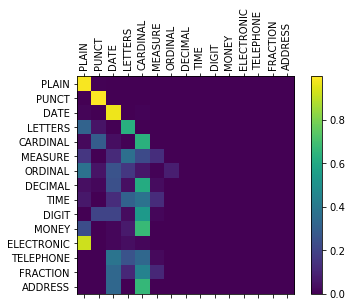

In [234]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(len(categories_all), len(categories_all))
n_confusion = 100000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    # category_i = categories_all.index(category)
    category_i = categories_index[category]
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(len(categories)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(categories_all), rotation=90)
ax.set_yticklabels([''] + list(categories_all))

# Force label at every tick
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Predicting

In [205]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, categories_all[category_index]))
        predictions.append([value, categories_all[category_index]])

predict('Normal')
predict('2017-12-12')
predict('~')


> Normal
(-0.00) PLAIN
(-7.46) LETTERS
(-9.83) CARDINAL

> 2017-12-12
(-0.04) DATE
(-4.71) MEASURE
(-5.05) CARDINAL

> ~
(-0.32) PUNCT
(-1.85) PLAIN
(-3.41) CARDINAL
